# MAT330 - 6. A neural network
<span style="color:blue"> **This notebook train a deep neural networks** </span>

<span style="color:red"> *- Can you play with the network architecture to improve the prediction?* </span>




In [1]:
%matplotlib inline
import os
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Input, Dense, Conv2D, Flatten, Concatenate
import keras

from keras.models import Model

Using TensorFlow backend.


## Load data

In [2]:
#Specify the categorical features
categorical_features = ['basin','nature']


train_filename = 'https://raw.githubusercontent.com/brajard/MAT330-Practical-work/master/data/train.csv'

data_train = pd.read_csv(train_filename, dtype={cat: 'category' for cat in categorical_features})

# Extract the predictor (but not the target -> data leakage)
X = data_train.drop('target',axis=1, inplace=False)
y = data_train['target']

# Do the same with the test dataset
test_filename = 'https://raw.githubusercontent.com/brajard/MAT330-Practical-work/master/data/test.csv'

Xtest = pd.read_csv(test_filename, dtype={cat: 'category' for cat in categorical_features})


## Deep-learning model

In [3]:

def extract_image(df,sparam):
    grid_l=11 # size of all 2D-grids (in pixels)
    N = df.shape[0] #Number of samples
    images = np.zeros(shape=(N,grid_l,grid_l))
    for i in range(grid_l):
        for j in range(grid_l):
            images[:,i,j] = df[sparam+'_'+str(i)+'_'+str(j)]
    return images
    

### 1. Feature selection

In [4]:
from sklearn.preprocessing import StandardScaler

#Features 0D to use
features = ['latitude', 'instant_t','longitude', 'windspeed',
       'hemisphere', 'Jday_predictor', 'initial_max_wind',
       'max_wind_change_12h','dist2land']


Xin0D = X.get(features)
Xin0D_test = Xtest.get(features)

# Equalization of the types:
Xin0D = Xin0D.astype(float)
Xin0D_test = Xin0D_test.astype(float)

# Dummy encoding of categorical features
Xcat = pd.get_dummies(X[categorical_features],prefix=categorical_features)
Xcat_test = pd.get_dummies(Xtest[categorical_features],prefix=categorical_features)

#Image features
Xz = extract_image(X,'z')
Xu = extract_image(X,'u')
Xv = extract_image(X,'v')
Xz_test = extract_image(Xtest,'z')
Xu_test = extract_image(Xtest,'u')
Xv_test = extract_image(Xtest,'v')


#Stack the 3 images togegher
X2d = np.stack((Xz,Xu,Xv),axis=-1)
X2d_test = np.stack((Xz_test,Xu_test,Xv_test),axis=-1)


Text(0.5, 0, 'param v')

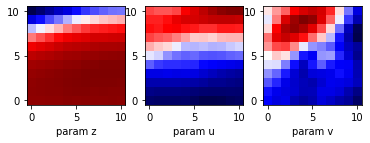

In [5]:
## Have a look an image
sample_id = 20 # sample number plotted - you can change it to see other storms and other instants
params = ['z','u','v']
fig, ax = plt.subplots(ncols = 3)
ax[0].imshow(Xz[20],interpolation='nearest', origin='lower', cmap='seismic')
ax[0].set_xlabel('param z')
ax[1].imshow(Xu[20],interpolation='nearest', origin='lower', cmap='seismic')
ax[1].set_xlabel('param u')
ax[2].imshow(Xv[20],interpolation='nearest', origin='lower', cmap='seismic')
ax[2].set_xlabel('param v')

### 2. Construct the model

In [6]:
keras.backend.clear_session() #To reset the keras state

#Input for the 0d layer:
size_0d = Xin0D.shape[1]
input_0d = Input(shape=(size_0d,),name='input_0d')
###########################


#Input for the categorical data:
size_cat = Xcat.shape[1]
input_cat = Input(shape=(size_cat,))
embedding = Dense(2,activation = 'relu', name='embedding')(input_cat)
############################

#Input for image data:
image_width = 11
nchannel = X2d.shape[-1] #Number of image parameters
nfilter1 = 10 #Number of filters of the firsgt layer
nfilter2 = 1 #Number of filters of the second layer

input_im = Input(shape=(image_width, image_width, nchannel),name='input_im2d')
#First convolutional lauer
layer_im1 = Conv2D(filters = nfilter1, kernel_size = 5, activation = 'relu')(input_im) #output size: nfilter1x7x7
layer_im2 = Conv2D(filters = nfilter2, kernel_size = 5, activation = 'relu')(layer_im1) #output size: nfilter2x4x4
flayer = Flatten(name='input_im0d')(layer_im2) #reshape to a 1-d layer: 16x1
############################


# Concatenate all the inputs
input_layer = Concatenate(name='input_layer')([input_0d, embedding, flayer])

# Add some 3 Dense layers
nhid1, nhid2, nhid3 = 64, 32, 16 #size of the layers
hidden1 = Dense(nhid1,activation = 'relu')(input_layer)
hidden2 = Dense(nhid2,activation = 'relu')(hidden1)
hidden3 = Dense(nhid3,activation = 'relu')(hidden2)
output = Dense(1, activation = 'linear',name='output')(hidden3)

## The final model
nnmodel = Model([input_0d, input_cat, input_im],output)


In [7]:
#Summary of the model
nnmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_im2d (InputLayer)         (None, 11, 11, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 10)     760         input_im2d[0][0]                 
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 3, 1)      251         conv2d_1[0][0]                   
__________________________________________________________________________________________________
input_0d (

In [8]:
keras.utils.plot_model(nnmodel, 'my_nnmodel.png')

<img src="my_nnmodel.png" width="70%">

### 3. Train into Val/Train

In [9]:
from sklearn.utils import shuffle
np.random.seed(10)
ids = shuffle(X.stormid.unique())

#Take 80% for training
limit_train = int(.8*len(ids))

#Index of training/val
idx_train = np.argwhere(X.stormid.isin(ids[:limit_train])).ravel()
idx_val = np.argwhere(X.stormid.isin(ids[limit_train:])).ravel()

Xin0D_train, Xcat_train, X2d_train, y_train = Xin0D.iloc[idx_train], Xcat.iloc[idx_train], X2d[idx_train],y.iloc[idx_train]
Xin0D_val, Xcat_val, X2d_val, y_val = Xin0D.iloc[idx_val], Xcat.iloc[idx_val], X2d[idx_val],y.iloc[idx_val]



### 3. Standardization
For all features (expect qualitative), transform your data such that mean=0 and std=1 (on the training data), and use the same parameters for transforming the test data also. 

In [10]:
scaler_0D = StandardScaler().fit(Xin0D_train)
scaler_im = lambda X: (X - X2d_train.mean(axis=(0,1,2),keepdims=True))/X2d_train.std(axis=(0,1,2),keepdims=True)

Xin0D_train_scaled = scaler_0D.transform(Xin0D_train)
Xin0D_val_scaled = scaler_0D.transform(Xin0D_val)
Xin0D_test_scaled = scaler_0D.transform(Xin0D_test)


X2d_train_scaled = scaler_im(X2d_train)
X2d_val_scaled = scaler_im(X2d_val)
X2d_test_scaled = scaler_im(X2d_test)



### 4. Training


In [11]:
# Compile the model with a optimizer and a loss
nnmodel.compile(optimizer='Adam',loss='mean_squared_error')

#Now train the model on very few epochs (to optimize try increasing the number of epochs)
#Now train the model on very few epochs (to optimize try increasing the number of epochs)
history  = nnmodel.fit([Xin0D_train_scaled, Xcat_train, X2d_train_scaled],y_train,
            validation_data = ([Xin0D_val_scaled, Xcat_val, X2d_val_scaled], y_val),
            epochs=10)

Train on 8300 samples, validate on 2008 samples
Epoch 1/10
8300/8300 [==============================] - 3s 322us/step - loss: 1042.5399 - val_loss: 455.1868
Epoch 2/10
8300/8300 [==============================] - 2s 255us/step - loss: 266.5119 - val_loss: 183.6737
Epoch 3/10
8300/8300 [==============================] - 3s 305us/step - loss: 189.7920 - val_loss: 162.6869
Epoch 4/10
8300/8300 [==============================] - 3s 304us/step - loss: 175.6063 - val_loss: 156.5647
Epoch 5/10
8300/8300 [==============================] - 2s 251us/step - loss: 167.3446 - val_loss: 152.7841
Epoch 6/10
8300/8300 [==============================] - 2s 238us/step - loss: 161.4389 - val_loss: 148.9130
Epoch 7/10
8300/8300 [==============================] - 2s 237us/step - loss: 159.0524 - val_loss: 152.7262
Epoch 8/10
8300/8300 [==============================] - 2s 271us/step - loss: 156.3564 - val_loss: 147.3838
Epoch 9/10
8300/8300 [==============================] - 2s 231us/step - loss: 156.3178 

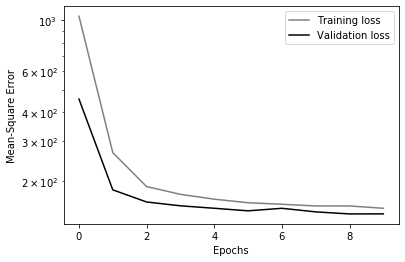

In [12]:
# Plot iterations
plt.semilogy(history.history['loss'],color='gray',label='Training loss')
plt.semilogy(history.history['val_loss'],color='black', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean-Square Error')
plt.legend()
plt.show()

### 5. Validate the model

In [ ]:
y_val_predict = nnmodel.predict([Xin0D_val_scaled, Xcat_val, X2d_val_scaled])
plt.scatter(y_val,y_val_predict)
plt.plot([0,140],[0,140],'-k')
plt.show()

In [ ]:
from sklearn.metrics import r2_score
score = r2_score(y_val,y_val_predict)
print('linear regression score: {:.3f}'.format(score))

### 3. Predicting the test dataset

In [ ]:
#Change the name for the file (e.g. you last name, or a name for you algo)
name = 'neural_net'

y_test_predict = nnmodel.predict([Xin0D_test_scaled, Xcat_test, X2d_test_scaled])
np.save('test_predict.' + name + '.npy',y_test_predict)

#Send the file by email to julien.brajard@nersc.no